# Modelos Generativos

Las redes neuronales hoy en día han sido aplicados a muchos problemas, de los cuales algunos son necesarios tener un modelo generativo el cual pueda artificialmente sintetizar nuevos ejemplos que sean similares a los originales, éste tipo de aprendizaje se llama **Unsupervised Learning**. Existen diferentes *approaches* para ésto, de los cuales solo veremos 2.

Vamos a trabajar con los datos anteriormente trabajos de MNIST.

In [1]:
from keras.datasets import mnist
import keras
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D, Reshape,Conv2DTranspose,Activation, Lambda
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K

from IPython.display import Image, display, SVG

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

import numpy as np

/home/fefi/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
channel = 1
img_rows, img_cols = X_train.shape[1:]
print(img_rows, img_cols, channel)

28 28 1


### 1.1 *Variational Autoencoder* (VAE) [[1]](#refs)

Los VAE son una variación a la arquitectura que ya vimos (autoencoder) en donde la codificación y decodificación están conectadas a través de un enfoque bayesiano en donde la codificación aprende los parámetros de alguna distribución de variables latentes de los datos y en donde el decodificador muestrea de ésta distribución de variables latentes para poder generar nuevos datos artificiales $\hat{x}$. Dicho de otra palabras es un autoencoder que aprende el modelo de las variables latentes de los datos.


El enfoque optimizador de los parámetros de la red neuronal $\theta$ es que minimiza la reconstrucción de los datos (al igual que un autoencoder tradicional), en base a alguna medicicón de error (*mse* por ejemplo) agregando una regularización que se impone para que la distribución aprendida de las variables latentes sea de alguna distribución deseada *a priori*.  

$$ Min \ L(q_{\theta}(x\mid z),x) + KL( q_{\theta}(z\mid x) \mid \mid p_{\theta}(z))$$

Con $L$ la función de pérdida de reconstrucción, $KL$ la *KL Divergence* [[5]](#refs), $q_{\hat{\theta}}(x\mid z)$ la recontrucción aleatoria de los datos a través de las variables latentes $z$ y  $p_{\theta}(z)$ una distribución *a priori*. 

<img src="https://i.imgur.com/ZN6MyTx.png" title="VAE" width="60%" />


> a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 bloque convolucionales y una bloque *fully conected*, con una distribución Normal multivariada de 2 componentes para las variables latentes. Describa la arquitectura utilizada para el *encoder*.

Como se mencionó más arriba, variational autoencoder tiene un codificador, que toma como *input* los datos de entrada original (*x*), y entrega como *output* una representación oculta de *x*, que llamaremos *z*, el cual tiene pesos entre las neuronas como parámetros del encoder.

A continuación se fijan los siguientes parámetros:  **PREGUNTAR**

In [4]:
# input image dimensions
original_img_size = (img_rows, img_cols, channel)
# number of convolutional filters to use
filters = 32
# convolution kernel size
num_conv = 3
latent_dim = 2
intermediate_dim = 128

In [5]:
print("Dimensiones de la imagen a procesar: ", original_img_size)
print("Cantidad de filtros convolucionales: ", filters)
print("Tamaño del kernel convolucional: ", num_conv)
print("Dimensiones de la capa intermedia entre x y z: ", intermediate_dim)
print("Dimensiones latentes de z: ", latent_dim)

Dimensiones de la imagen a procesar:  (28, 28, 1)
Cantidad de filtros convolucionales:  32
Tamaño del kernel convolucional:  3
Dimensiones de la capa intermedia entre x y z:  128
Dimensiones latentes de z:  2


Una vez definidos los hiper-parámetro, se procede a definir y explicar la arquitectura del encoder.

In [6]:
## Encoder
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

In [7]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

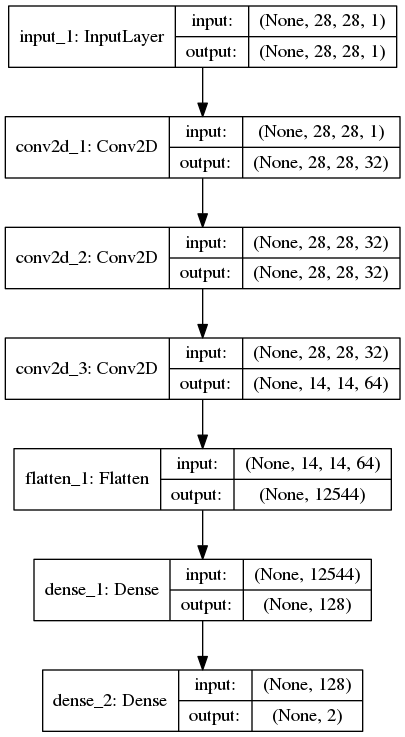

In [8]:
plot_model(encoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png')

La arquitectura del autoencoder consta de una capa de entrada que recibe imágenes de dimensiones 28x28x1. Luego tiene 3 capas convolucionales, donde la primera y segunda tiene 32 filtros, y la tercera tiene el doble, 64. Todas estas capas tienen el kernel convolucional de 3x3 y función de activación ReLU. Las primeras dos capas mantienen dimensiones de entrada de imagen de 28x28 y la tercera tiene como input 28x28 y output 14x14, debido al parámetro *stride=2*.

Luego, viene una capa *flatten* que "aplana" la entrada, es decir de 3 dimensiones pasa a 1, en este caso pasa de una capa de 14x14x64 a una de 12.544, que justamente corresponde a la multiplicación de las 3 dimensiones de entrada. 

Finalmente, hay dos capas densas, que se encargan de reducir la dimensionalidad de los <a id="1_dense_enc">12.544</a>, obtenidos en el *flatten* a 2 dimensiones correspondientes a las dos componentes de las variables latentes. Pasando por <a id="2_dense_enc">128</a> neuronas entre las dos capas densas.

> b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y con 3 bloque de la operación inversa a una convolución (**Convolución transpuesta** [[2]](#refs)), comente cómo ésta trabaja y los parámetros de stride como funcionan. Además se *setea* la distribución de las variables latentes como una distribución Normal multivariada de 2 componentes.

Por otro lado, variational autoencoder tiene un decodificador, otra red neuronal, que se encarga de tomar como input la representación *z* obtenida en el encoder, y como output entrega muestras de la distribución de variables latentes. Desde otro punto de vista, el dencoder se puede ver como la  probabilidad de encontrar muestras de X dada las componentes latentes encontradas en el encoder, $P(\hat x | z)$. Por lo tanto, el decoder intenta recontruir los datos originales.

A continuación se define la arquitectura que tendrá el decoder, que dicho de una forma simplista, es básicamente es el encoder, pero al revés.

In [9]:
## Decoder
shape_before_flattening = K.int_shape(conv_3)[1:]
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu') #128
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu') #14x14x64=12544
decoder_reshape = Reshape(shape_before_flattening)#14x14x64
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

La arquitectura del decoder primero cuenta con dos capas densas:
* *decoder_hid* = Recostruye la capa de 128 neuronas con función de activación ReLU. Esta capa hace [referencia](#2_dense_enc) a la última capa densa del encoder.   
* *decoder_upsample* = Reconstituye la capa de 12.544 neuronas, hace [referencia](#1_dense_enc) a la primera capa densa del encoder. 

Luego viene una capa que lleva los datos a una dimension de 14x14x64, que 

## Explicación convolución transpuesta, parámetro stride, normal

In [26]:
decoder_upsample.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_5',
 'trainable': True,
 'units': 12544,
 'use_bias': True}

In [25]:
decoder_reshape.get_config()

{'name': 'reshape_1', 'target_shape': (14, 14, 64), 'trainable': True}

In [20]:
decoder_hid.get_config()

{'activation': 'relu',
 'activity_regularizer': None,
 'bias_constraint': None,
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'bias_regularizer': None,
 'kernel_constraint': None,
 'kernel_initializer': {'class_name': 'VarianceScaling',
  'config': {'distribution': 'uniform',
   'mode': 'fan_avg',
   'scale': 1.0,
   'seed': None}},
 'kernel_regularizer': None,
 'name': 'dense_4',
 'trainable': True,
 'units': 128,
 'use_bias': True}

> c) Defina la sección que conecta a estas dos partes a través de un *sampleo* implicito ($g = \mu_{z^{(i)}} + \sigma_{z^{(i)}}\cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilistico/bayesiano. Describa el modelo completo.

In [10]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon


In [11]:
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

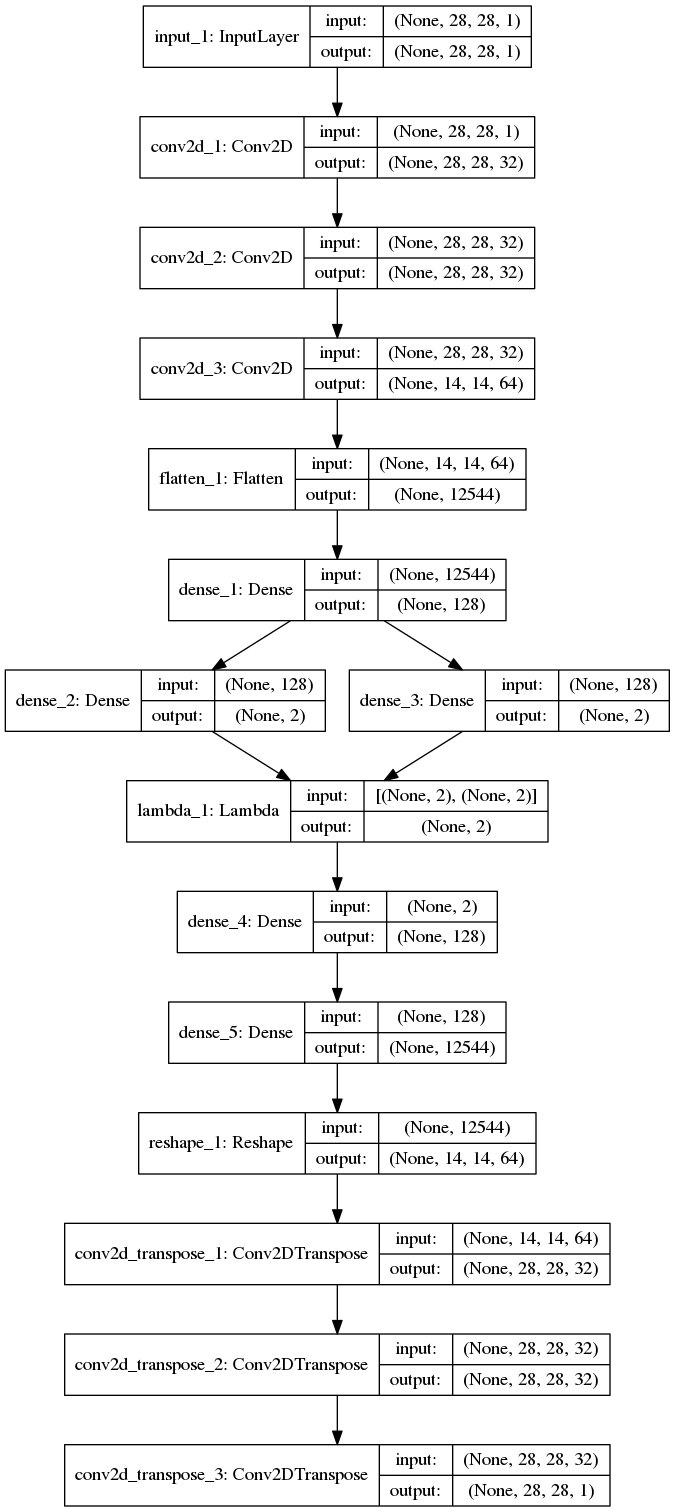

In [12]:
plot_model(vae, to_file='vae.png', show_shapes=True)
Image(filename='vae.png')

## Explicar modelo

> d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.

### Explicar KL

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [13]:
# Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash)) 
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel * choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

### EXPLICAR KL como reg

> e) Entrene el modelo definido con los datos de MNIST entre 10 a 15 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

In [14]:
print(X_test.shape)
print(X_train.shape)

(10000, 28, 28)
(60000, 28, 28)


In [15]:
x_train = X_train.reshape(X_train.shape[0], original_img_size[0], original_img_size[1], original_img_size[2])
x_test = X_test.reshape(X_test.shape[0], original_img_size[0], original_img_size[1], original_img_size[2])

In [16]:
print(x_test.shape)
print(x_train.shape)

(10000, 28, 28, 1)
(60000, 28, 28, 1)


In [17]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 

In [19]:
batch_size = 256
epochs = range(10,16)
hist_vae = []
vae.compile(optimizer='rmsprop')
for i in epochs:
    hist_vae.append(vae.fit(x_train, epochs=i, batch_size=batch_size, validation_data=(x_test, None)))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "conv2d_transpose_3" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "conv2d_transpose_3" during training.
  after removing the cwd from sys.path.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 416s 7ms/step - loss: nan - val_loss: nan
Epoch 2/10
60000/60000 [==============================] - 415s 7ms/step - loss: nan - val_loss: nan
Epoch 3/10
60000/60000 [==============================] - 415s 7ms/step - loss: nan - val_loss: nan
Epoch 4/10
60000/60000 [==============================] - 420s 7ms/step - loss: nan - val_loss: nan
Epoch 5/10
60000/60000 [==============================] - 418s 7ms/step - loss: nan - val_loss: nan
Epoch 6/10
60000/60000 [==============================] - 445s 7ms/step - loss: nan - val_loss: nan
Epoch 7/10
60000/60000 [==============================] - 437s 7ms/step - loss: nan - val_loss: nan
Epoch 8/10
60000/60000 [==============================] - 471s 8ms/step - loss: nan - val_loss: nan
Epoch 9/10
60000/60000 [==============================] - 423s 7ms/step - loss: nan - val_loss: nan
Epoch 10/10
60000/60000 [=========================

> f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_{z^{(i)}}$. Además genere un histograma de la media y la varianza $\sigma_{z^{(i)}}^2$ de las dos componentes. Comente



ValueError: c of shape (10000,) not acceptable as a color sequence for x with size 60000, y with size 60000

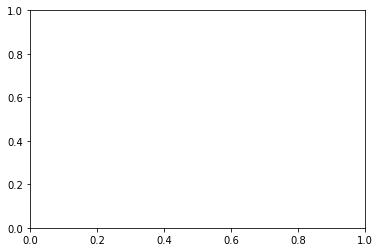

In [21]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)

plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
encoder_log_var = Model(x,z_log_var)
#histogram

> g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?



In [ ]:
#GENERATOR
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

In [ ]:
##PLOT
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
#metodo de la transformada inversa
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
#en los extremos del intervalo de confianza
grid = norm.ppf(np.linspace(0.000005, 0.999995, n))